In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
%matplotlib inline

TODO: make a figure showing the average trace as a function of probability (like that of Anna or of Santos & Kowler)

In [2]:
t_titre = 35
t_label = 25
fig_width = 15
exts = ['.png', '.svg']
dpi = 400

In [3]:
observer = 'LB'
mode = 'enregistrement'
from aSPEM import Analysis
e = Analysis()#observer=observer, mode=mode)

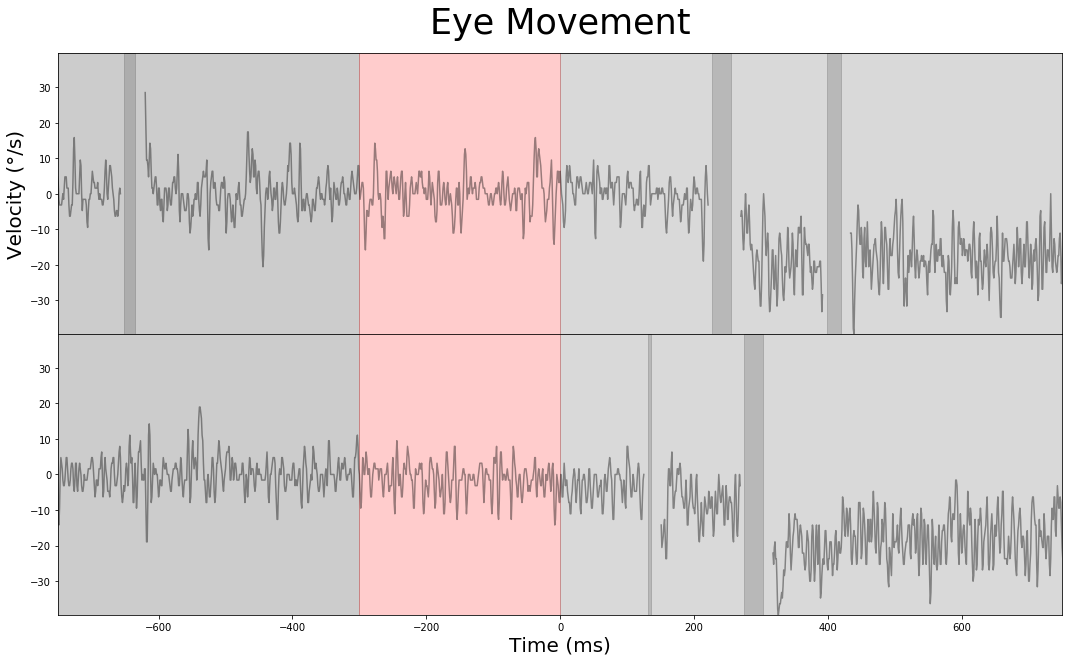

In [4]:
fig, axs = e.plot_velocity(trials=[19, 71])
for ext in exts: fig.savefig('figures/raw_trace' + ext, dpi=dpi)

TypeError: type object got multiple values for keyword argument 'nan_policy'

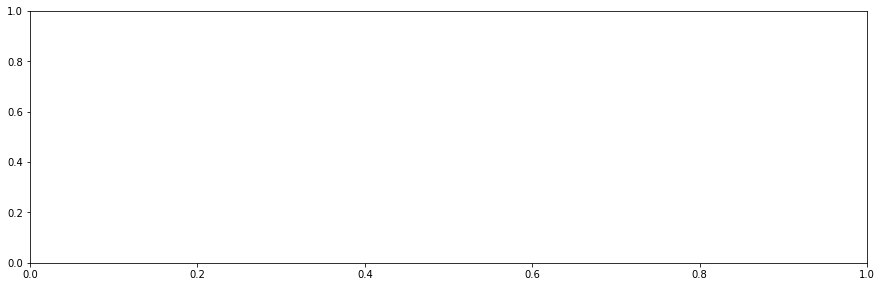

In [5]:
fig, axs= e.plot_Fit()
for ext in exts: fig.savefig('figures/raw_fit' + ext, dpi=dpi)

In [ ]:
fig, axs = e.plot_Fit(plot='velocity', trials=[19, 71])
for ext in exts: fig.savefig('figures/raw_fitted' + ext, dpi=dpi)

In [ ]:
fig, axs, result = e.plot_Fit(
    plot='velocity', report=True, trials=[19, 71, 83])

In [ ]:
for x in range(len(result)) :
    print('essai',x ,'\n', result[0])

### Fit

In [ ]:
# pour générer les paramètre fit ainsi que les figures de tout les essais
#e.Fit()